Template based extraction of training dataset

In [2]:
import sys
sys.path.append('C:/Users/Anusha/Documents/GitHub/miniML/core/')

from miniML import MiniTrace, EventDetection
import template_matching as tm
import numpy as np
import h5py
import matplotlib.pyplot as plt
import copy
from scipy import signal
import re, struct, collections #import all packages from here on too
import datetime
import os, sys
import pyqtgraph as pg
from FileImport.HekaReader import Bundle #to read .dat files

import matplotlib
%matplotlib inline

series_data: [(array([3.07451747e-11, 2.94831293e-11, 3.17885489e-11, ...,
       1.02213180e-11, 1.07961109e-11, 1.00713720e-11]), 0.0001)]
series_resistances: [20.003667837656938]


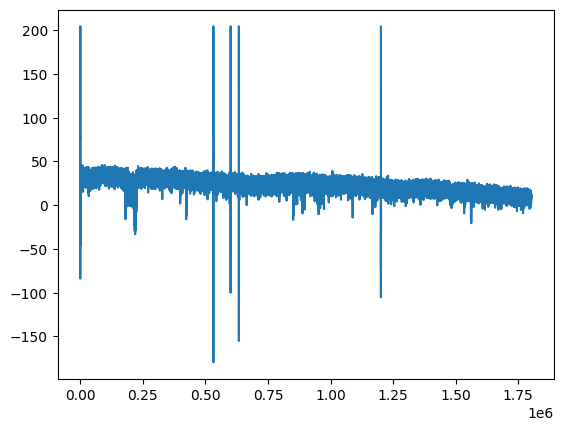

In [6]:
path = 'C:/Users/Anusha/Documents/GitHub/miniML/model_training/extract_training_data/example_recordings/'
myfile = 'Melina_030724_S3_hippocampus_LAA_NMDA.dat'
save_id = 'Melina_rec1'
filename = path + myfile

rectype = '1minLoop'
group = 3 #add group number (numbering starts from 1)
scaling = 1e12
unit = 'pA'
exclude_series = [16,27] #exclude the series in the group that is not needed (numbering starts from 0)
exclude_sweeps = {3:[]} #exclude the sweeps in the series that is not needed (numbering starts from 0)
label = 'cell1-1' #add name of the cell
trace = MiniTrace.from_heka_file(filename=filename,
                            group=group,
                            exclude_series = exclude_series,
                            exclude_sweeps = exclude_sweeps,
                            rectype=rectype,
                            scaling=scaling,
                            unit=unit
                            )
trace_time = np.linspace(0,len(trace.data),len(trace.data))/10000 #10000 is the sampling rate; this is to get the timestamp of the datastretch when plotting it for scoring
plt.plot(trace.data)
plt.show()

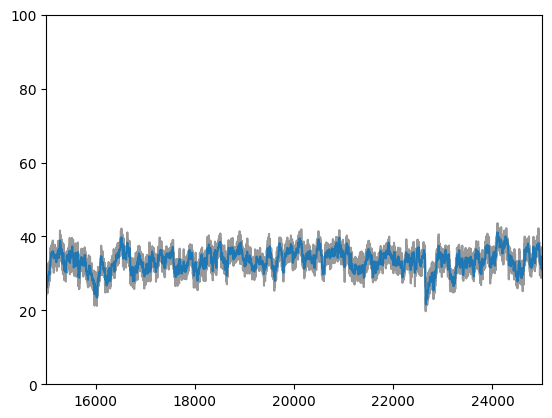

In [7]:
# For template matching it can be useful to filter the data. We use a Hann window here.
filter_data = True
if filter_data:
    win = signal.windows.hann(15)
    tmplt_trace = signal.convolve(trace.data, win, mode='same') / sum(win)
else:
    tmplt_trace = trace.data

plt.plot(trace.data, c='k', alpha=0.4) #aplha value controls opacity of plot and c is the colour 
plt.plot(tmplt_trace)
plt.ylim(0,100) #(-40,40) for trace 2
plt.xlim(15000,25000)
plt.show()

In [1]:
# Estimate roughly event shape based on window size; can be adjusted later
#this was changed for every input file
win_size = 350
baseline = (win_size/12) * trace.sampling 
duration = int(win_size*2.5/3) * trace.sampling
t_rise = (baseline+(win_size * trace.sampling))/50
t_decay = (baseline+(win_size * trace.sampling))/5

template = tm.make_template(t_rise=t_rise, t_decay=t_decay, baseline=baseline, duration=duration, sampling=trace.sampling)

# Run template matching to extract a few events to adjust template.
matching = tm.template_matching(tmplt_trace, template, threshold=-4)
print(f'found {len(matching.indices)} events')

# Get average event form
events = []
for ind in matching.indices:
    if ind < tmplt_trace.shape[0] - win_size:
        events.append(tmplt_trace[ind:ind+win_size])
events = np.array(events)

mean_ev = np.mean(events, axis=0)

# Scale the event
mean_ev -= np.mean(mean_ev[0:int(win_size/10)])
mean_ev /= np.min(mean_ev) # Needs to be adjusted for positive events.
plt.plot(template, label='template')
plt.plot(mean_ev,label='event')
plt.legend()
plt.show()

NameError: name 'trace' is not defined

In [9]:
%matplotlib qt
# Plot template and average event and use this to adjust template.
baseline = (win_size/10) * trace.sampling #when the baseline starts before event; if you increase, template starts later
duration = int(win_size*2/3) * trace.sampling #how long the decay line goes
t_rise = (baseline+(win_size * trace.sampling))/13 #if you decrease, then fatter
t_decay = (baseline+(win_size * trace.sampling))/7 #if you increase, then thinner 

template = tm.make_template(t_rise=t_rise, t_decay=t_decay, baseline=baseline, duration=duration, sampling=trace.sampling)
plt.plot(template, label='template')
plt.plot(mean_ev,label='event')
plt.legend()
plt.show()

In [17]:
cell_label, idx, events, scores= [], [], [], [] #added cell label

# Set the different thresholds.
threshold_high = -7.0
threshold_mid = -5.0
threshold_low = -2.5

# Run template matching with a high threshold to extract events with high confidence.
matching = tm.template_matching(tmplt_trace, template, threshold=threshold_high)
print(f'found {len(matching.indices)} events with high threshold')

found 59 events with high threshold


In [18]:
%matplotlib qt

# Plot the output to make sure the result makes sense
fig, axs = plt.subplots(2, 1, sharex=True)
axs[0].plot(matching.detection_trace)
axs[0].axhline(threshold_high, c='orange', zorder=2, ls='--')
axs[1].plot(trace.data)
axs[1].scatter(matching.indices, tmplt_trace[matching.indices], c='orange', zorder=2)
plt.show()

In [19]:
# Extract clear events

event_counter = 0
for ind, location in enumerate(matching.indices):
    if location < trace.data.shape[0] - int(win_size*1.5):
        event = copy.deepcopy(trace.data[location:location+win_size])
        event -= np.mean(event[:int(win_size/10)])
        
        cell_label.append(label)
        idx.append(location)
        events.append(event)
        scores.append(1)
        event_counter += 1

print(f'{event_counter} events extracted\n')


# generate list with all indices of +/- (win_size/30) points of the previously found events to prevent duplicates (or at least keep them to a minimum)
idx_range = []
buffer = int(win_size/30)
for my_ind in idx:
    idx_range += list(range(my_ind-buffer, my_ind+buffer))

# Run tmplt matching with a relatively low threshold to extract FPs and small events.
matching = tm.template_matching(tmplt_trace, template, threshold=threshold_mid)
print(f'found {len(matching.indices)} events with mid threshold')
unclear_counter = 0
for ind, location in enumerate(matching.indices):
    if location < trace.data.shape[0] - int(win_size*1.5):
        if location not in idx_range:
            event = copy.deepcopy(trace.data[location:location+win_size])
            event -= np.mean(event[:int(win_size/10)])
            
            cell_label.append(label) #add cell label and link it to 'label'
            idx.append(location)
            events.append(event)
            scores.append(2)
            unclear_counter += 1

print(f'{unclear_counter} unclear events extracted\n')

59 events extracted

found 336 events with mid threshold
277 unclear events extracted



In [20]:
# Run tmplt matching with a very low threshold. Remaining parts of the trace should be event free.
matching = tm.template_matching(tmplt_trace, template, threshold=threshold_low)
print(f'found {len(matching.indices)} events with low threshold')

event_free_indices = []
for i in range(matching.indices.shape[0]-1):
    start = matching.indices[i] + win_size
    end = matching.indices[i+1] - win_size
    if end - start > 0:
        event_free_indices.append(np.arange(start, end))

event_free_indices = np.concatenate(event_free_indices)
unique_stretches = []
for ind, i in enumerate(event_free_indices):
    if ind==0:
        unique_stretches.append(i)
        next_possible = i+win_size
    
    if i < next_possible:
        pass
    else:
        unique_stretches.append(i)
        next_possible = i+win_size

# Extract unique stretches to prevent overlap and redundancy in the data
if len(unique_stretches) <= event_counter:
    inds = np.array(unique_stretches)
else:
    inds = np.random.choice(np.array(unique_stretches), event_counter, replace=False)

# Extract events
noise_counter = 0
for location in sorted(inds):
    event = copy.deepcopy(trace.data[location:location+win_size])
    event -= np.mean(event[:int(win_size/10)])
    cell_label.append(label)
    idx.append(location)
    events.append(event)
    scores.append(0)
    noise_counter += 1

print(f'{noise_counter} noise stretches extracted')

found 3499 events with low threshold
59 noise stretches extracted


In [21]:
# Save the result
x = np.array(events)
y = np.array(scores)
indices = np.array(idx)

save_dataset = f'C:/Users/Anusha/Documents/GitHub/miniML/model_training/extract_training_data/output/trace1.h5'

if save_dataset:
    with h5py.File(save_dataset, 'w') as f:
        f.create_dataset("events", data=x)
        f.create_dataset("scores", data=y)
        f.create_dataset("raw_indices", data=indices)
        f.create_dataset("cell_label", data=np.array(cell_label, dtype='S')) #store cell label in dataset too